# **1. SET-UP**

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/sample_data/MyDrive')

Mounted at /content/sample_data/MyDrive


In [3]:
import cv2
import imghdr
import os
import tensorflow as tf
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
data_dir = "/content/sample_data/MyDrive/MyDrive/classification/classifier"

In [5]:
os.listdir(data_dir)

['cow', 'horse', 'dog', 'cat', 'zebra', 'sheep']

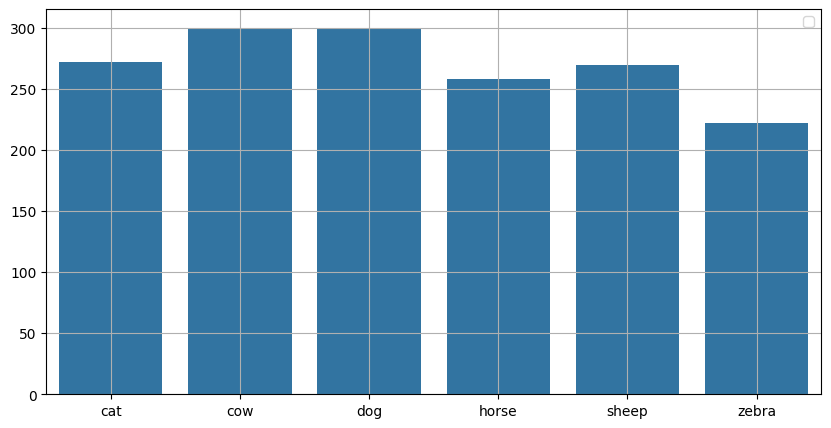

In [6]:
# for displaying no of images per class
class_names = sorted(os.listdir(data_dir))

num_classes = len(class_names)

class_sizes = []
for name in class_names:
    class_size = len(os.listdir(data_dir + "/" + name))
    class_sizes.append(class_size)

plt.figure(figsize=(10,5))
sns.barplot(x=class_names, y=class_sizes)
plt.grid()

plt.legend()

plt.show()

# **2. DATA LOADING**

In [7]:
dataset = tf.keras.utils.image_dataset_from_directory(data_dir, label_mode='categorical')

Found 1620 files belonging to 6 classes.


In [8]:
data_iterator = dataset.as_numpy_iterator()

In [9]:
batch = data_iterator.next()

In [10]:
len(batch)

2

In [11]:
batch[1]

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0.

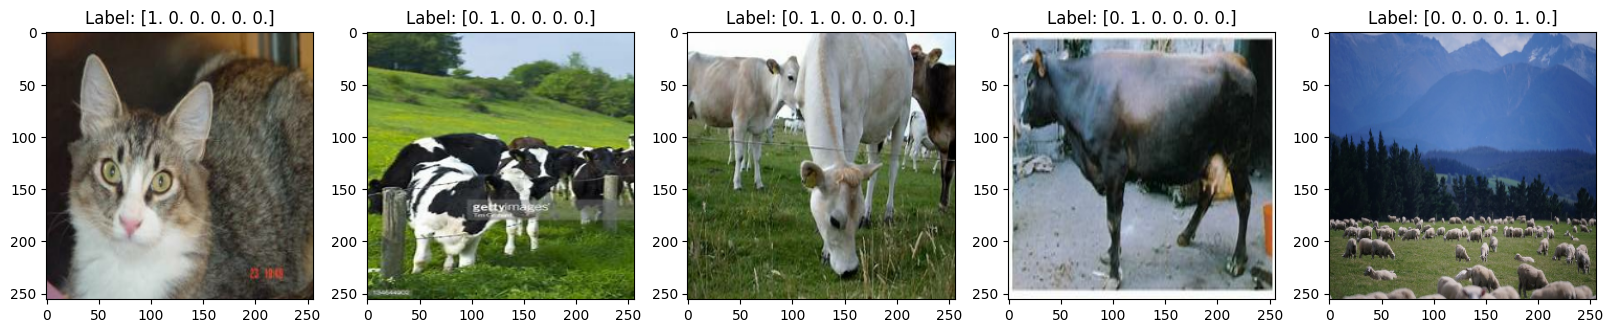

In [12]:
fig, ax = plt.subplots(ncols=5, figsize = (20,20))
for idx, img in enumerate (batch[0][:5]):
  ax[idx].imshow(img.astype(int))
  ax[idx].set_title(f'Label: {batch[1][idx]}')


# **3. DATA PRE-PROCESSING**

In [13]:
batch[0].shape

(32, 256, 256, 3)

In [14]:
batch[0].min()

0.0

In [15]:
# resizing the dataset
import tensorflow as tf

def resize_function(x, y):
    resized_x = tf.image.resize(x, (128, 128))

    return resized_x, y

# Apply the resize function to each element in the dataset
dataset = dataset.map(resize_function)


In [16]:
# Normalizing the dataset
dataset = dataset.map(lambda x,y : (x/255,y))

In [17]:
scaled_iterator = dataset.as_numpy_iterator()

In [18]:
scaled_batch = scaled_iterator.next()

In [19]:
scaled_batch[0].shape

(32, 128, 128, 3)

In [20]:
scaled_batch[0].max()

1.0

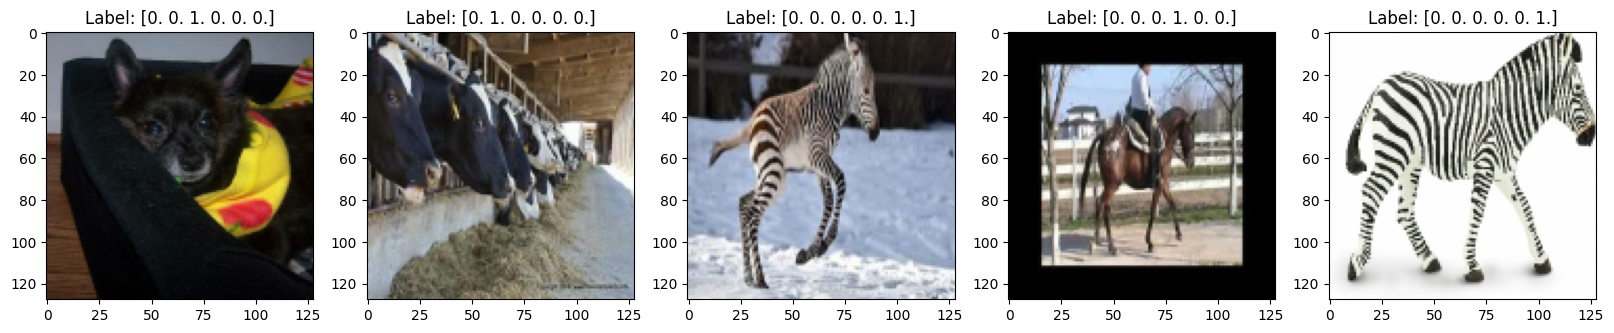

In [21]:
fig, ax = plt.subplots(ncols=5, figsize = (20,20))
for idx, img in enumerate (scaled_batch[0][:5]):
  ax[idx].imshow(img)
  ax[idx].set_title(f'Label: {scaled_batch[1][idx]}')


Train/Test Split

In [22]:
len(dataset)

51

In [23]:
train_size = int(len(dataset)*.75)+1
val_size = int(len(dataset)*.1)+1
test_size = int(len(dataset)*.1)+1

In [24]:
train_data = dataset.take(train_size)
val_data = dataset.skip(train_size).take(val_size)
test_data = dataset.skip(train_size+val_size).take(test_size)

In [25]:
def extract_features_labels(image, label):
    return image, label

x_train, y_train = zip(*train_data.map(extract_features_labels))
x_val, y_val = zip(*val_data.map(extract_features_labels))
x_test, y_test = zip(*test_data.map(extract_features_labels))

In [26]:
x_train = tf.concat(x_train, axis=0).numpy()
y_train = tf.concat(y_train, axis=0).numpy()
x_val = tf.concat(x_val, axis=0).numpy()
y_val = tf.concat(y_val, axis=0).numpy()
x_test = tf.concat(x_test, axis=0).numpy()
y_test = tf.concat(y_test, axis=0).numpy()

In [27]:
print(y_train.shape)
print(x_train.shape)
print(y_val.shape)
print(x_val.shape)
print(y_test.shape)
print(x_test.shape)

(1248, 6)
(1248, 128, 128, 3)
(192, 6)
(192, 128, 128, 3)
(180, 6)
(180, 128, 128, 3)


# **4. MODEL DEVELOPMENT**

In [30]:
!pip install vit_keras

In [33]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.0 MB/s eta 0:00:00


In [34]:
from vit_keras import vit
import tensorflow_addons as tfa

vit_model = vit.vit_b16(
        image_size = 128,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 6)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


347502902/347502902 [==============================] - 5s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 8, 8
  warnings.warn(


In [41]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(32, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(6, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85697280  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_2 (Bat  (None, 768)               3072      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 128)               98432     
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 64)         

In [42]:
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = 1e-4)

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])


# **5. Training**

In [43]:
# initialize the number of epochs and batch size
EPOCHS = 30
BS = 32


early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)

# train the model
history = model.fit(
    x_train,y_train, batch_size=BS,
    validation_data=(x_val,y_val),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    callbacks=early_stopping_callbacks)

Epoch 1/30
39/39 [==============================] - 49s 555ms/step - loss: 1.9817 - accuracy: 0.1667 - val_loss: 1.8352 - val_accuracy: 0.1823
Epoch 2/30
39/39 [==============================] - 20s 520ms/step - loss: 1.8231 - accuracy: 0.2524 - val_loss: 1.7025 - val_accuracy: 0.2917
Epoch 3/30
39/39 [==============================] - 20s 513ms/step - loss: 1.6393 - accuracy: 0.3614 - val_loss: 1.5344 - val_accuracy: 0.4271
Epoch 4/30
39/39 [==============================] - 20s 506ms/step - loss: 1.4931 - accuracy: 0.4792 - val_loss: 1.4223 - val_accuracy: 0.4948
Epoch 5/30
39/39 [==============================] - 20s 503ms/step - loss: 1.3639 - accuracy: 0.5865 - val_loss: 1.3329 - val_accuracy: 0.5625
Epoch 6/30
39/39 [==============================] - 19s 497ms/step - loss: 1.2573 - accuracy: 0.6915 - val_loss: 1.1985 - val_accuracy: 0.7135
Epoch 7/30
39/39 [==============================] - 20s 513ms/step - loss: 1.1591 - accuracy: 0.7660 - val_loss: 1.1088 - val_accuracy: 0.8021

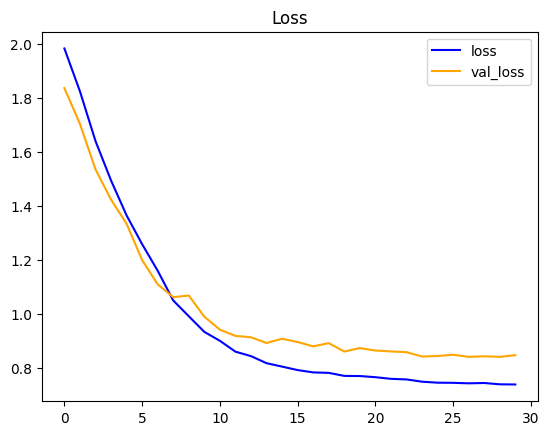

In [44]:
from matplotlib import pyplot as plt
fig = plt.figure()
plt.plot(history.history['loss'], color= 'blue', label = 'loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'val_loss')
plt.title('Loss')
plt.legend(loc = 'upper right')
plt.show()

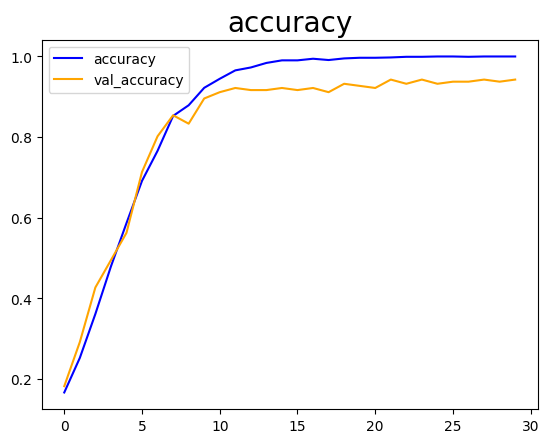

In [45]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color= 'blue', label = 'accuracy')
plt.plot(history.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
plt.title('accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

# **6. TESTING**

In [46]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [47]:
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()

In [48]:
yhat = model.predict(x_test)
precision.update_state(y_test,yhat)
recall.update_state(y_test,yhat)
accuracy.update_state(y_test,yhat)


6/6 [==============================] - 4s 138ms/step


<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=180.0>

In [49]:
print("Precision: {} " .format(precision.result()))
print("Recall: {} " .format(recall.result()))
print("Accuracy: {} " .format(accuracy.result()))


Precision: 0.9314285516738892 
Recall: 0.9055555462837219 
Accuracy: 0.9277777671813965 


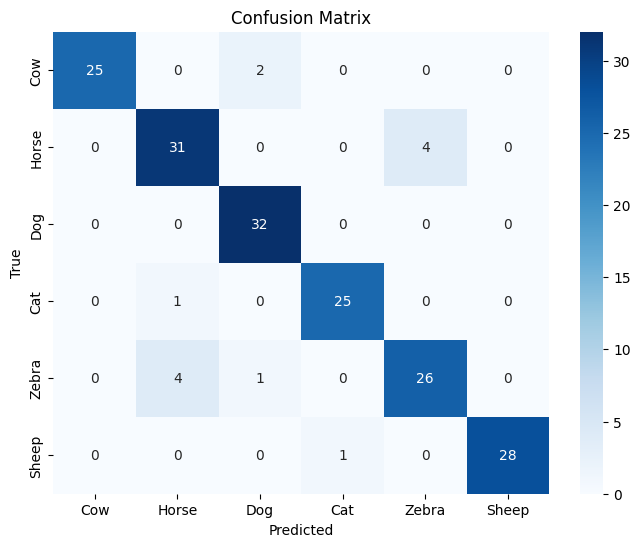

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(yhat, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cow', 'Horse', 'Dog', 'Cat', 'Zebra', 'Sheep'], yticklabels=['Cow', 'Horse', 'Dog', 'Cat', 'Zebra', 'Sheep'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [52]:
def Prediction(predictions):
    if np.array_equal(predictions, np.array([[1, 0, 0, 0, 0, 0]])):
        return "cat"
    elif np.array_equal(predictions, np.array([[0, 1, 0, 0, 0, 0]])):
        return "cow"
    elif np.array_equal(predictions, np.array([[0, 0, 1, 0, 0, 0]])):
        return "dog"
    elif np.array_equal(predictions, np.array([[0, 0, 0, 1, 0, 0]])):
        return "horse"
    elif np.array_equal(predictions, np.array([[0, 0, 0, 0, 1, 0]])):
        return "sheep"
    elif np.array_equal(predictions, np.array([[0, 0, 0, 0, 0, 1]])):
        return "zebra"
    else:
        return "Unidentified"


1/1 [==============================] - 0s 88ms/step
dog


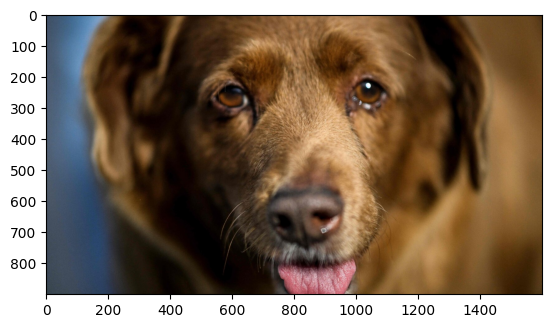

In [53]:
test = cv2.imread("/content/sample_data/MyDrive/MyDrive/classification/classifier/dog/16xp-dog-01-lchw-videoSixteenByNineJumbo1600.jpg")
plt.imshow(cv2.cvtColor(test, cv2.COLOR_BGR2RGB))
resize = tf.image.resize(test, (128,128))
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat = np.round(yhat)
print(Prediction(yhat))

1/1 [==============================] - 0s 74ms/step
sheep


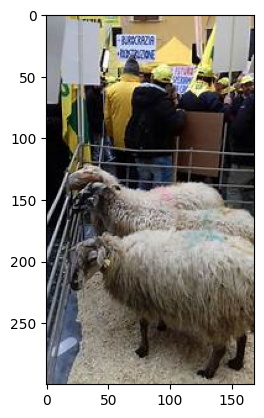

In [54]:
test = cv2.imread("/content/sample_data/MyDrive/MyDrive/classification/classifier/sheep/OIP-FdLjMEzlRR-40hikM7l1OgHaNK.jpeg")
plt.imshow(cv2.cvtColor(test, cv2.COLOR_BGR2RGB))
resize = tf.image.resize(test, (128,128))
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat = np.round(yhat)
print(Prediction(yhat))

In [ ]:
7. Conclusion 

The accuracy of VGG-16 and vision Transformer is pretty much the same. but the loss in vision trnsformer after 30 epochs is greater than the VGG-16